# Filterkennlinie Messung mit AD9833 und MCC118

## Einführung

### Was ist eine Filterkennlinie?
Eine **Filterkennlinie** beschreibt, wie ein Filter verschiedene Frequenzen unterschiedlich stark durchlässt oder dämpft. Sie wird im **Bode-Diagramm** dargestellt, welches die Verstärkung (in dB) über der Frequenz (logarithmisch) zeigt.

### Ziel des Experiments
Wir messen die Übertragungsfunktion eines Filters, indem wir:
1. Mit dem **AD9833** verschiedene Sinusfrequenzen erzeugen
2. Mit dem **MCC118** die Ausgangsamplitude messen
3. Die Filterkennlinie als Bode-Diagramm darstellen

### Hardware-Setup
- **AD9833**: DDS (Direct Digital Synthesis) Signalgenerator
- **MCC118**: 8-Kanal Analog-Digital-Wandler
- **Filter**: Das zu messende Filter (zwischen Generator und ADC)

---

## Schritt 1: Bibliotheken importieren
Wir benötigen verschiedene Python-Bibliotheken für die Hardware-Steuerung und Datenvisualisierung:

In [1]:
import time                     # Für Wartezeiten
import spidev                   # SPI-Kommunikation mit AD9833
import RPi.GPIO as GPIO         # GPIO-Steuerung für Raspberry Pi
import matplotlib.pyplot as plt # Diagramme erstellen
import numpy as np             # Numerische Berechnungen

from daqhats import mcc118, HatIDs           # MCC118 Hardware-Bibliothek
from daqhats_utils import select_hat_device  # Device-Auswahl

## Schritt 2: AD9833 Parameter definieren

### Was ist der AD9833?
Der **AD9833** ist ein programmierbarer DDS-Generator, der über SPI gesteuert wird. Er kann Sinus-, Dreieck- und Rechteckwellen mit hoher Frequenzauflösung erzeugen.

### Wichtige Parameter:

In [2]:
# === AD9833 Hardware-Parameter ===
FMCLK = 25_000_000  # Master Clock: 25 MHz Taktfrequenz
MAX_FREQ = 50000    # Maximale Ausgangsfrequenz: 50 kHz
FSYNC_PIN = 25      # GPIO Pin für Frame Sync (Chip Select)
SPI_BUS = 0         # SPI Bus Nummer
SPI_DEVICE = 0      # SPI Device Nummer  
SPI_FREQ = 1000000  # SPI Übertragungsfrequenz: 1 MHz

# === AD9833 Register und Steuerbits ===
FREQ0_REG = 0x4000   # Frequenzregister 0
CONTROL_REG = 0x2000 # Kontrollregister
SINE_WAVE = 0x2000   # Sinuswelle auswählen
RESET = 0x2100       # Reset-Befehl

### Erklärung der Register:
- **FREQ0_REG**: Hier wird die gewünschte Frequenz gespeichert
- **CONTROL_REG**: Steuert Wellenform und Betriebsmodus
- **SINE_WAVE**: Aktiviert die Sinuswellen-Ausgabe
- **RESET**: Setzt den AD9833 zurück

---

## Schritt 3: Hardware-Initialisierung

### GPIO und SPI Setup
Der AD9833 kommuniziert über die **SPI-Schnittstelle**. Zusätzlich benötigen wir einen GPIO-Pin für das **FSYNC-Signal** (Frame Synchronisation).

In [3]:
def init_ad9833():
    """
    Initialisiert GPIO und SPI für die Kommunikation mit dem AD9833
    
    Ablauf:
    1. GPIO konfigurieren (BCM-Nummerierung)
    2. FSYNC Pin als Ausgang definieren
    3. SPI-Schnittstelle öffnen und konfigurieren
    4. AD9833 zurücksetzen
    """
    # GPIO Modus setzen (BCM = Broadcom Pin-Nummerierung)
    GPIO.setmode(GPIO.BCM)
    GPIO.setup(FSYNC_PIN, GPIO.OUT)
    GPIO.output(FSYNC_PIN, GPIO.HIGH)  # FSYNC initial auf HIGH

    # SPI-Schnittstelle konfigurieren
    global spi
    spi = spidev.SpiDev()
    spi.open(SPI_BUS, SPI_DEVICE)
    spi.max_speed_hz = SPI_FREQ
    spi.mode = 0b10  # SPI Mode 2 (CPOL=1, CPHA=0)

    # AD9833 initialisieren
    write_ad9833(RESET)
    time.sleep(0.1)  # Kurz warten bis Reset abgeschlossen

## Warum SPI Mode 2?
- **CPOL=1**: Clock-Polarität invertiert (Clock ist normalerweise HIGH)
- **CPHA=0**: Daten werden bei der steigenden Flanke gelesen

---

## Schritt 4: AD9833 Kommunikationsfunktionen

### SPI-Datenübertragung
Der AD9833 erwartet 16-Bit Datenwörter über SPI:

In [4]:
def write_ad9833(data):
    """
    Sendet ein 16-Bit Datenwort an den AD9833
    
    Parameter:
    data: 16-Bit Datenwort (Register + Daten)
    
    Ablauf:
    1. FSYNC auf LOW (Übertragung beginnt)
    2. 16-Bit Daten in 2 Bytes aufteilen und senden
    3. FSYNC auf HIGH (Übertragung beendet)
    """
    GPIO.output(FSYNC_PIN, GPIO.LOW)   # Übertragung starten
    spi.xfer2([data >> 8, data & 0xFF])  # High-Byte, dann Low-Byte
    GPIO.output(FSYNC_PIN, GPIO.HIGH)  # Übertragung beenden

### Frequenz einstellen
Die Frequenzberechnung basiert auf der DDS-Formel:

**Frequenz = (Frequenzwort × FMCLK) / 2²⁸**

In [5]:
def set_ad9833_freq(freq_hz):
    """
    Stellt die Ausgangsfrequenz des AD9833 ein
    
    Parameter:
    freq_hz: Gewünschte Frequenz in Hz
    
    DDS-Prinzip:
    - 28-Bit Frequenzwort bestimmt die Ausgangsfrequenz
    - Muss in zwei 14-Bit Paketen übertragen werden
    """
    # Frequenzwort berechnen (28-Bit)
    word = int((freq_hz * 2**28) / FMCLK)
    
    # Übertragungssequenz (wichtig für korrekte Funktion!)
    write_ad9833(RESET)                                    # 1. Reset
    write_ad9833(FREQ0_REG | (word & 0x3FFF))             # 2. Lower 14 Bits
    write_ad9833(FREQ0_REG | ((word >> 14) & 0x3FFF))     # 3. Upper 14 Bits  
    write_ad9833(SINE_WAVE)                                # 4. Sinuswelle aktivieren

### Warum zwei 14-Bit Pakete?
Der AD9833 hat nur 16-Bit Register, aber benötigt 28-Bit für die Frequenz. Daher wird das Frequenzwort in zwei Teile aufgeteilt.

---

## Schritt 5: Messung durchführen

### Hauptmessschleife
Hier führen wir die eigentliche Filtermessung durch:

=== Filterkennlinie Messung ===



Startfrequenz [Hz] (z.B. 1000):  10
Endfrequenz [Hz] (z.B. 10000):  100
Anzahl Messpunkte (z.B. 30):  20



🔧 Initialisiere Hardware...
✅ Hardware bereit!

📊 Starte Messung von 10 Hz bis 100 Hz...
[  5.0%] f =    10.0 Hz → U = 1.7395 V
[ 10.0%] f =    11.3 Hz → U = 1.7447 V
[ 15.0%] f =    12.7 Hz → U = 1.7447 V
[ 20.0%] f =    14.4 Hz → U = 1.7447 V
[ 25.0%] f =    16.2 Hz → U = 1.7447 V
[ 30.0%] f =    18.3 Hz → U = 1.7447 V
[ 35.0%] f =    20.7 Hz → U = 1.7447 V
[ 40.0%] f =    23.4 Hz → U = 1.7395 V
[ 45.0%] f =    26.4 Hz → U = 1.7447 V
[ 50.0%] f =    29.8 Hz → U = 1.7395 V
[ 55.0%] f =    33.6 Hz → U = 1.7395 V
[ 60.0%] f =    37.9 Hz → U = 1.7395 V
[ 65.0%] f =    42.8 Hz → U = 1.7395 V
[ 70.0%] f =    48.3 Hz → U = 1.7395 V
[ 75.0%] f =    54.6 Hz → U = 1.7395 V
[ 80.0%] f =    61.6 Hz → U = 1.7395 V
[ 85.0%] f =    69.5 Hz → U = 1.7395 V
[ 90.0%] f =    78.5 Hz → U = 1.7447 V
[ 95.0%] f =    88.6 Hz → U = 1.7447 V
[100.0%] f =   100.0 Hz → U = 1.7447 V
✅ Messung abgeschlossen!


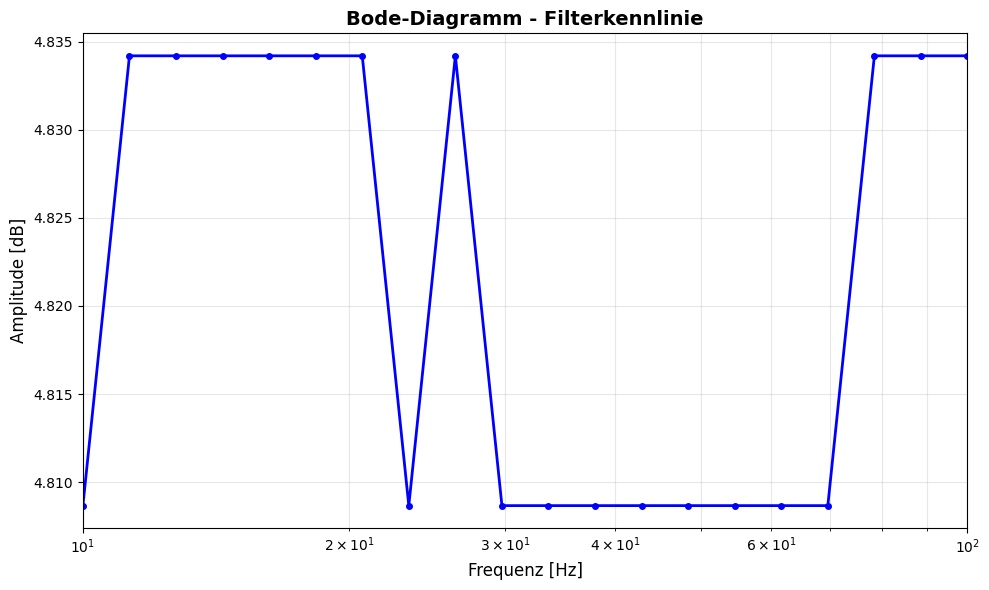

🧹 Hardware-Cleanup abgeschlossen.


In [6]:
def main():
    """
    Hauptfunktion für die Filterkennlinienmessung
    
    Ablauf:
    1. Messparameter vom Benutzer abfragen
    2. Hardware initialisieren  
    3. Frequenzen logarithmisch verteilen
    4. Für jede Frequenz: Signal erzeugen und Amplitude messen
    5. Bode-Diagramm erstellen und anzeigen
    """
    try:
        # === Messparameter eingeben ===
        print("=== Filterkennlinie Messung ===\n")
        f_start = float(input("Startfrequenz [Hz] (z.B. 1000): "))
        f_stop = float(input("Endfrequenz [Hz] (z.B. 10000): "))
        num_points = int(input("Anzahl Messpunkte (z.B. 30): "))

        # Sicherheitsprüfung
        if f_stop > MAX_FREQ:
            print(f"⚠️  Begrenze Endfrequenz auf {MAX_FREQ} Hz.")
            f_stop = MAX_FREQ

        # === Hardware initialisieren ===
        print("\n🔧 Initialisiere Hardware...")
        init_ad9833()
        hat = mcc118(select_hat_device(HatIDs.MCC_118))
        print("✅ Hardware bereit!")

        # === Frequenzverteilung berechnen ===
        # Logarithmische Verteilung für bessere Auflösung bei niedrigen Frequenzen
        frequenzen = np.logspace(np.log10(f_start), np.log10(f_stop), num=num_points)
        amplituden = []

        print(f"\n📊 Starte Messung von {f_start:.0f} Hz bis {f_stop:.0f} Hz...")
        print("=" * 60)
        
        # === Messschleife ===
        for i, f in enumerate(frequenzen):
            # Frequenz am Generator einstellen
            set_ad9833_freq(f)
            time.sleep(0.1)  # Warten bis Signal stabil (wichtig!)
            
            # Ausgangsamplitude messen (MCC118 Kanal 7)
            u = hat.a_in_read(7)
            amplituden.append(u)
            
            # Fortschritt anzeigen
            progress = (i + 1) / num_points * 100
            print(f"[{progress:5.1f}%] f = {f:7.1f} Hz → U = {u:.4f} V")

        # Generator ausschalten
        write_ad9833(RESET)
        print("✅ Messung abgeschlossen!")

        # === Datenauswertung ===
        # Amplitude in dB umrechnen: dB = 20 * log10(U/U_ref)
        # Hier verwenden wir U_ref = 1V, daher: dB = 20 * log10(U)
        amplituden_db = 20 * np.log10(np.maximum(amplituden, 1e-6))  # Minimum für log

        # === Bode-Diagramm erstellen ===
        plt.figure(figsize=(10, 6))
        plt.semilogx(frequenzen, amplituden_db, 'bo-', linewidth=2, markersize=4)
        plt.grid(True, which='both', alpha=0.3)
        plt.xlabel("Frequenz [Hz]", fontsize=12)
        plt.ylabel("Amplitude [dB]", fontsize=12)
        plt.title("Bode-Diagramm - Filterkennlinie", fontsize=14, fontweight='bold')
        
        # Achsen beschriften
        plt.xlim(f_start, f_stop)
        
        # Layout optimieren
        plt.tight_layout()
        plt.show()

    except KeyboardInterrupt:
        print("\n⚠️  Messung durch Benutzer abgebrochen.")
    except Exception as e:
        print(f"❌ Fehler: {e}")
    finally:
        # === Cleanup (immer ausführen!) ===
        try:
            write_ad9833(RESET)  # Generator stoppen
            spi.close()          # SPI schließen
            GPIO.cleanup()       # GPIO zurücksetzen
            print("🧹 Hardware-Cleanup abgeschlossen.")
        except:
            pass

# === Messung starten ===
if __name__ == "__main__":
    main()

---

## Schritt 6: Ergebnisse verstehen

### Das Bode-Diagramm interpretieren

#### Typische Filtertypen:
1. **Tiefpass-Filter**: 
   - Niedrige Frequenzen werden durchgelassen
   - Hohe Frequenzen werden gedämpft
   - Kennlinie fällt bei hohen Frequenzen ab

2. **Hochpass-Filter**:
   - Hohe Frequenzen werden durchgelassen  
   - Niedrige Frequenzen werden gedämpft
   - Kennlinie steigt bei hohen Frequenzen an

3. **Bandpass-Filter**:
   - Nur ein bestimmter Frequenzbereich wird durchgelassen
   - Kennlinie hat ein Maximum bei der Resonanzfrequenz

#### Wichtige Kenngrößen:
- **Grenzfrequenz (-3dB)**: Frequenz bei der die Amplitude um 3dB abgefallen ist
- **Steilheit**: Wie schnell die Dämpfung zunimmt (dB/Dekade)
- **Passband**: Frequenzbereich mit geringer Dämpfung
- **Sperrband**: Frequenzbereich mit starker Dämpfung

#### Mathematischer Hintergrund:
- **dB-Skala**: dB = 20 × log₁₀(U_out/U_in)
- **-3dB**: Entspricht 70.7% der ursprünglichen Amplitude
- **-20dB**: Entspricht 10% der ursprünglichen Amplitude

---

## Tipps für die Praxis

### Messgenauigkeit verbessern:
- **Einschwingzeit**: Immer genug Zeit warten nach Frequenzänderung
- **Messpunkte**: Mehr Punkte für bessere Auflösung
- **Frequenzbereich**: Logarithmische Verteilung für gleichmäßige Auflösung

### Häufige Probleme:
- **Rauschen**: Mehrfachmessung und Mittelwertbildung
- **Übersteuering**: Eingangspegel prüfen
- **Schwingungen**: Abschirmung und kurze Leitungen verwenden